In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances

In [50]:
df = pd.read_csv('/content/81-90.csv')


In [51]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [52]:
from sklearn.neighbors import NearestNeighbors
X_train = train_df[['cit_2017', 'cit_2018', 'cit_2019', 'cit_2020', 'cit_2021']]
nn = NearestNeighbors(metric='euclidean')
nn.fit(X_train)


NearestNeighbors(metric='euclidean')

###Elbow Method to determine optimal value of k

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

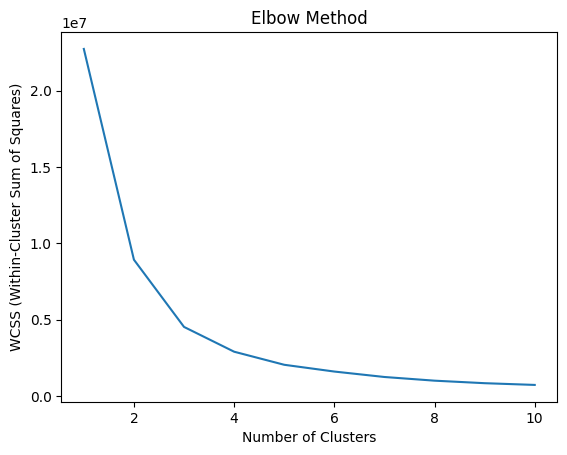

In [53]:
import matplotlib.pyplot as plt

inertia = []
range_values = range(1, 11)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=40)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)


plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')

plt.show()

In [54]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
train_df['cluster'] = kmeans.fit_predict(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


###Average difference magnitude to evaluate: same as the 2022 citation number of the nearest neighbor from the training set

In [55]:
from sklearn.metrics import mean_absolute_error
import numpy as np


X_test = test_df[['cit_2017', 'cit_2018', 'cit_2019', 'cit_2020', 'cit_2021']]
test_df['cluster'] = kmeans.predict(X_test)


nearest_neighbors = nn.kneighbors(X_test, n_neighbors=1, return_distance=False)
predictions_1 = train_df.iloc[nearest_neighbors.squeeze()]['cit_2022'].values
true_values = test_df['cit_2022'].values
mae_1 = mean_absolute_error(true_values, predictions_1)


### Average difference magnitude to evaluate: same as the point nearest the cluster centroid;


In [60]:
columns = ['cit_2017', 'cit_2018', 'cit_2019', 'cit_2020', 'cit_2021']
X_test = test_df[columns]
test_df['predicted_cluster'] = kmeans.predict(X_test)

# Prediction function
def nearest_point_to_centroid_in_training(test_row, centroids, train_data, columns):
    cluster = test_row['predicted_cluster']
    cluster_data = train_data[train_data['cluster'] == cluster]

    # Check if there's data in this cluster
    if cluster_data.empty:
        print(f"Warning: No training data for cluster {cluster}.")
        return None

    distances_to_centroid = cluster_data.apply(lambda row: euclidean_distances(row[columns].values.reshape(1, -1), centroids[cluster].reshape(1, -1))[0][0], axis=1)

    return cluster_data.loc[distances_to_centroid.idxmin()]['cit_2022']

# Apply prediction function to each test row
test_df['pred_2022_centroid'] = test_df.apply(lambda row: nearest_point_to_centroid_in_training(row, kmeans.cluster_centers_, train_df, columns), axis=1)

test_df['diff'] = abs(test_df['cit_2022'] - test_df['pred_2022_centroid'])
mae_2 = test_df['diff'].mean()


### Average difference magnitude to evaluate: average of all others from the training set in the same cluster.

In [61]:
columns = ['cit_2017', 'cit_2018', 'cit_2019', 'cit_2020', 'cit_2021']
X_train = train_df[columns]

kmeans = KMeans(n_clusters=4)  # we choose optimal k value here
train_df['cluster'] = kmeans.fit_predict(X_train)

X_test = test_df[columns]
test_df['predicted_cluster'] = kmeans.predict(X_test)

# Prediction function
def average_cit_2022_from_cluster(test_row, train_data):
    cluster = test_row['predicted_cluster']
    cluster_data = train_data[train_data['cluster'] == cluster]

    # Compute the average cit_2022 for the cluster
    return cluster_data['cit_2022'].mean()

# Apply prediction function to each test row
test_df['pred_2022_average_cluster'] = test_df.apply(lambda row: average_cit_2022_from_cluster(row, train_df), axis=1)

test_df['diff'] = abs(test_df['cit_2022'] - test_df['pred_2022_average_cluster'])
mae_3 = test_df['diff'].mean()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


###Results of Average Difference Magnitude for all three prediction

In [70]:
print("Predicted Values for:")
print("Nearest Neigbor")
print(predictions_1)
print("Cluster Centroid")
print(test_df['pred_2022_centroid'])
print("Average of cluster")
print(test_df['pred_2022_average_cluster'])

print("Actual Values")
print(test_df['cit_2022'])

Predicted Values for:
Nearest Neigbor
[ 319  296  663  203  152  325  436  152  194  325  335  366   23  589
   73  733  495 1196  212  109]
Cluster Centroid
83     315
53     315
70     315
45     133
44     133
39     315
22     315
80     133
10     133
0      315
18     315
30     315
73     133
33     315
90     133
4     1025
76     133
77     315
12     133
31     133
Name: pred_2022_centroid, dtype: int64
Average of cluster
83     391.826087
53     391.826087
70     391.826087
45     146.647059
44     146.647059
39     391.826087
22     391.826087
80     146.647059
10     146.647059
0      391.826087
18     391.826087
30     391.826087
73     146.647059
33     391.826087
90     146.647059
4     1133.250000
76     146.647059
77     391.826087
12     146.647059
31     146.647059
Name: pred_2022_average_cluster, dtype: float64
Actual Values
83     339
53     360
70     622
45     215
44      83
39     344
22     411
80     101
10     220
0      298
18     648
30     312
73       5

In [62]:
print(f"Average Difference Magnitude for Prediction for nearest neighbor from the training set: {mae_1}")
print(f"Average Difference Magnitude for Prediction using point near centroid: {mae_2}")
print(f"Average Difference Magnitude for Prediction using average of training set in same cluster: {mae_3}")

Average Difference Magnitude for Prediction for nearest neighbor from the training set: 82.5
Average Difference Magnitude for Prediction using point near centroid: 160.0
Average Difference Magnitude for Prediction using average of training set in same cluster: 158.67746163682864
